In [2]:
import os
import pandas as pd
from PIL import Image

import wandb
import math

from ipywidgets import IntProgress
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score

import sys
from glob import glob
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from time import time

import torch
import torch.utils.data as data

import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize
import albumentations as A
import cv2
import albumentations.pytorch

import matplotlib.pyplot as plt
import seaborn as sns
import random

SEED값 고정

In [3]:
# Set random seed
import random
SEED = 2021
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)  # type: ignore
torch.backends.cudnn.deterministic = True  # type: ignore
torch.backends.cudnn.benchmark = True  # type: ignore

## DataSet 고정

In [4]:
class MaskDataset(data.Dataset):
    def __init__(self, img_dir, transform=None):
        """
        img_dir: 학습 이미지 폴더(images)의 root directory(./train/train/images)
        transforms안넣으면 totensor변환만 해서 내보냄
        """
        self.transform = transform
        self.img_dir = img_dir
        self.path = []
        self.label = []
        self.class_num = 18
        self.setup()

    
    def setup(self):
        filenames = os.listdir(self.img_dir)
        for i in filenames:
            if not i.startswith("._"):
                img_name = os.listdir(os.path.join(self.img_dir, i))
                for j in img_name:
                    if not j.startswith('._'):
                        self.path.append(i+'/'+j)
                        gender = 0 if i.split('_')[1] == 'male' else 1
                        age = int(i.split('_')[3])
                        age_range = 0 if age < 30 else 1 if age < 60 else 2
                        if 'incorrect' in j:
                            mask = 1
                        elif 'mask' in j:
                            mask=0
                        elif 'normal' in j:
                            mask=2
                        self.label.append(mask * 6 + gender * 3 + age_range)
                
    def __getitem__(self, index):
        y = self.label[index]
        img_path = self.path[index]
    
        img = Image.open(os.path.join(self.img_dir,img_path))
        if self.transform != None:
            X = self.transform(img)
        else:
            tt = transforms.ToTensor()
            X = tt(img)
        return X, y
        
    def __len__(self):
        return len(self.path)

In [5]:
mean, std = np.array([0.485,0.456,0.406]),np.array([0.229,0.224,0.220])

Train Test Split

In [6]:
# 정의한 Augmentation 함수와 Dataset 클래스 객체를 생성합니다.

transform = transforms.Compose([
        Resize((int(512 / 2), int(384/ 2))),
        ToTensor(),
        Normalize(mean=mean, std=std)
    ])

dataset = MaskDataset(
    img_dir = '/opt/ml/input/data/train/images_origin',
    transform=transform
)

# valid_datset = MaskDataset(
#     img_dir = '/opt/ml/input/data/eval/images',
#     transform=transform
# )

# train dataset과 validation dataset을 8:2 비율로 나눕니다.
n_val = int(len(dataset) * 0.2)
n_train = len(dataset) - n_val
train_dataset, val_dataset = data.random_split(dataset, [n_train, n_val])

In [7]:
dataset[0]

(tensor([[[-0.6452, -0.5938, -0.6281,  ...,  0.4508,  0.5878,  1.2214],
          [-0.6109, -0.5596, -0.5938,  ...,  0.4679,  0.6392,  1.2728],
          [-0.5938, -0.5596, -0.5767,  ...,  0.4679,  0.7077,  1.3413],
          ...,
          [ 0.0227,  0.0056, -0.0287,  ..., -0.0287, -0.0116,  0.0056],
          [-0.0116, -0.0287, -0.0629,  ..., -0.0458, -0.0287, -0.0116],
          [-0.0801, -0.0801, -0.0972,  ..., -0.0629, -0.0458, -0.0287]],
 
         [[ 0.8179,  0.8179,  0.7129,  ...,  0.8004,  0.9405,  1.5882],
          [ 0.8529,  0.8704,  0.7654,  ...,  0.8179,  0.9930,  1.6408],
          [ 0.8880,  0.8880,  0.8004,  ...,  0.8179,  1.0630,  1.7108],
          ...,
          [-0.5301, -0.5476, -0.5826,  ..., -0.6527, -0.6352, -0.6176],
          [-0.5651, -0.5826, -0.6176,  ..., -0.6702, -0.6527, -0.6352],
          [-0.6352, -0.6352, -0.6527,  ..., -0.6877, -0.6702, -0.6527]],
 
         [[ 1.3096,  1.3275,  1.2561,  ...,  1.0066,  1.1492,  1.8087],
          [ 1.3453,  1.3631,

DataLoader 만들기

In [8]:
# training dataloader은 데이터를 섞어주어야 합니다. (shuffle=True)
batch_size = 16

train_loader = data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=4, 
#     cuda설정이안돼서 num_workers 설정하면 안돌아감
    shuffle=True,
    drop_last =True
)

val_loader = data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=4,
    shuffle=False
)
loader={'train':train_loader,
       'val':val_loader}

In [9]:
images, labels = next(iter(train_loader))
print(f'images shape: {images.shape}')
print(f'labels shape: {labels.shape}')

images shape: torch.Size([16, 3, 256, 192])
labels shape: torch.Size([16])


In [10]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0',num_classes=18)
print("네트워크 필요 입력 채널 개수", model._conv_stem.weight.shape[1])
print("네트워크 출력 채널 개수 (예측 class type 개수)", model._fc.weight.shape[0])

Loaded pretrained weights for efficientnet-b0
네트워크 필요 입력 채널 개수 3
네트워크 출력 채널 개수 (예측 class type 개수) 18


In [11]:
# weight및 bias 초기화
torch.nn.init.xavier_uniform_(model._fc.weight)
stdv = 1. / math.sqrt(model._fc.weight.size(1))
model._fc.bias.data.uniform_(-stdv, stdv)

tensor([-0.0257, -0.0207,  0.0024, -0.0246,  0.0141, -0.0246, -0.0205,  0.0052,
        -0.0235, -0.0279,  0.0020,  0.0239,  0.0128, -0.0080,  0.0118, -0.0154,
        -0.0111,  0.0220])

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
model.to(device)
LEARNING_RATE = 0.0001 
NUM_EPOCH = 5
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min')

In [14]:
best_val_accuracy = 0.
best_val_loss = 9999.

torch.cuda.empty_cache()

for epoch in range(NUM_EPOCH):
    for phase in ["train", "val"]:
        running_loss = 0.
        running_acc = 0.
        n_iter = 0
        epoch_f1 = 0
        if  phase == "val":
            confusion_matrix = np.zeros((18, 18))

        if phase == "train":
            model.train()
        elif phase == "val":
            model.eval()

        for ind, (images, labels) in enumerate(tqdm(loader[phase])):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() # parameter gradient를 업데이트 전 초기화함

            with torch.set_grad_enabled(phase == "train"): # train 모드일 시에는 gradient를 계산
                logits = model(images)
                _, preds = torch.max(logits, 1)
                loss = loss_fn(logits, labels)

                if phase == "train":
                    loss.backward() 
                    optimizer.step()
            # Metrics 계산 부분 ==============================================================================
            epoch_f1 += f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average='macro')
            n_iter += 1
            if  phase == "val":
                for t, p in zip(labels.view(-1), preds.view(-1)): # confusion matrix에 값 입력, 언제가 최적일 지 몰라 매 epoch돌아감
                    confusion_matrix[t.long(), p.long()] += 1    
            running_loss += loss.item() * images.size(0) # 한 Batch에서의 loss 값, images.size(0) = batch size
            running_acc += torch.sum(preds == labels.data) # 한 Batch에서의 Accuracy 값
            
            
    # 한 epoch이 모두 종료되었을 때,
    epoch_loss = running_loss / len(loader[phase].dataset)
    epoch_acc = running_acc / len(loader[phase].dataset)
    epoch_f1 = epoch_f1/n_iter

    print(f"epoch-{epoch}의 {phase}-데이터 평균 Loss : {epoch_loss:.3f}, 평균 Accuracy : {epoch_acc:.3f}, 평균 f1:{epoch_f1}")
    if phase == "val" and best_val_accuracy < epoch_acc: 
        best_val_accuracy = epoch_acc
    if phase == "val" and best_val_loss > epoch_loss: 
        best_val_loss = epoch_loss
print("학습 종료!")
print(f"최고 accuracy : {best_val_accuracy:3f}, 최고 낮은 loss : {best_val_loss:3f}")


epoch-0의 val-데이터 평균 Loss : 0.242, 평균 Accuracy : 0.923, 평균 f1:0.8545449312129217



epoch-1의 val-데이터 평균 Loss : 0.220, 평균 Accuracy : 0.920, 평균 f1:0.8440168683788419



epoch-2의 val-데이터 평균 Loss : 0.095, 평균 Accuracy : 0.969, 평균 f1:0.9373686071126796



epoch-3의 val-데이터 평균 Loss : 0.068, 평균 Accuracy : 0.981, 평균 f1:0.960976469197536



epoch-4의 val-데이터 평균 Loss : 0.069, 평균 Accuracy : 0.981, 평균 f1:0.9594148387276774
학습 종료!
최고 accuracy : 0.981481, 최고 낮은 loss : 0.067860


In [ ]:
import wandb
os.environ['WANDB_NOTEBOOK_NAME'] = 'first_v1.ipynb'

wandb.init(project='mask_classification',entity='junhyuk93',config={"batch_size": batch_size,
                   "lr"        : LEARNING_RATE,
                   "epochs"    : NUM_EPOCH,
                   "backborn"  : "effcientnet-b4",
                   "criterion_name" : "Cross_entropy"})

NameError: name 'batch_size' is not defined

In [18]:
# 파일을 저장
from pytz import timezone
import datetime as dt

now = (dt.datetime.now().astimezone(timezone("Asia/Seoul")).strftime("%Y-%m-%d-%H-%M"))
torch.save(model,f"save_model/{now}.pth")

Text(0.5, 69.0, 'Predicted label')

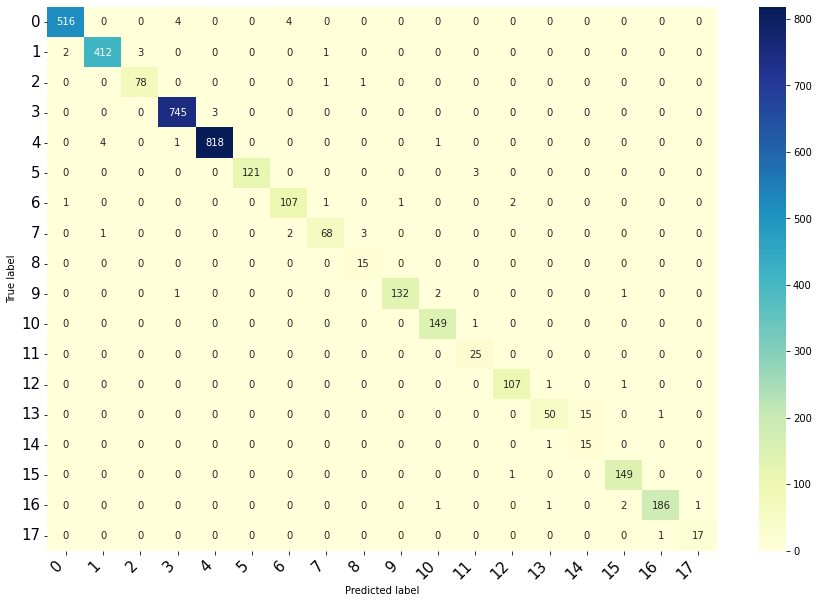

In [19]:
plt.figure(figsize=(15,10))

class_names=[str(i) for i in range(18)]
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='YlGnBu')

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [21]:
model = torch.load(f'save_model/{now}.pth')

In [22]:
class TestDataset(Dataset):
    """
    img_paths: image위치가 들어있는 주소 리스트
    """
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [24]:
test_dir = '/opt/ml/input/data/eval'
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]

transform = transforms.Compose([
            Resize((int(512 / 2), int(384/ 2))),
            ToTensor(),
            Normalize(mean=mean, std=std),
        ])
dataset = TestDataset(image_paths, transform)
loader = DataLoader(
    dataset,
    shuffle=False
)

In [25]:
# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')
model = model.to(device)
model.eval()

all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

In [ ]:
submission.to_csv(f'submission/submission_5.csv', index=False)